In [31]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [18]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0)

In [9]:
t_es = np.logspace(-2, 3, 20) #hours

In [10]:
alpha = 2
s.add_ffp(alpha)
diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=False)

In [11]:
diff_rates_finite = s.get_crossing_times_rates_ffp(t_es, finite=True)

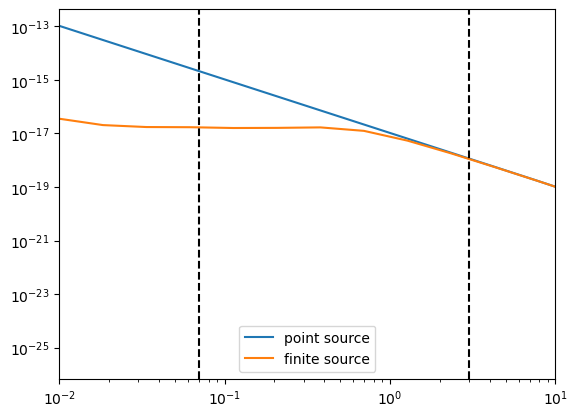

In [12]:
plt.loglog(t_es, diff_rates, label='point source')
plt.loglog(t_es, diff_rates_finite, label='finite source')

# Add lines for HSC sensitivity window
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
# plt.ylim(1e-16,1e-7)
plt.legend()
plt.show()

In [13]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [14]:
ti = 0.07
tf = 3
dnds = quad(diff_rate_interp, ti, tf)[0]

In [15]:
s.n_sources*efficiency*dnds

9.138756769859345e-09

In [62]:
def get_n_events(A, alpha=2, finite=False):
    #Now A is number of FFPs per star
    s.add_ffp(alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime*A

def get_n_events_parallel(As, alpha=2, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, alpha=alpha, finite=finite)
        results = list(p.imap(f, As))
    return results

In [63]:
n_events = get_n_events(1, alpha=alpha, finite=False)

In [ ]:
n_events_finite = get_n_events(1, alpha=alpha, finite=True)

## 2D exclusion plots

In [26]:
A_min = 1
A_max = 1e8
alpha_min = 1.1
alpha_max = 2.5
num_points = 20
A_values = np.logspace(np.log10(A_min), np.log10(A_max), num_points)
alpha_values = np.linspace(alpha_min, alpha_max, num_points) 
A_grid, alpha_grid = np.meshgrid(A_values, alpha_values)

get_n_events_values = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=False)
    

 30%|███       | 6/20 [15:27<36:44, 157.46s/it]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: In

In [27]:
get_n_events_values_finite = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values_finite[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=True)

100%|██████████| 20/20 [1:24:55<00:00, 254.77s/it]


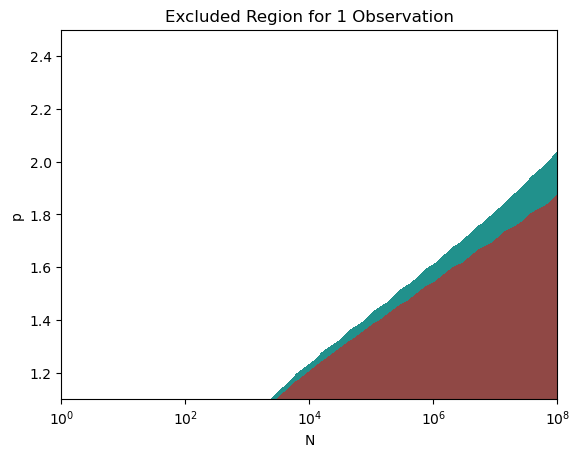

In [44]:
plt.figure()
contour = plt.contourf(A_grid, alpha_grid, get_n_events_values, levels=[4.74, 1e10])
plt.contourf(A_grid, alpha_grid, get_n_events_values_finite, levels=[4.74, 1e10], colors="red", alpha=0.5)
plt.xscale('log')
plt.title('Excluded Region for 1 Observation')
plt.xlabel('N')
plt.ylabel('p')
plt.show()

In [55]:
def get_constraint_iso(m_iso, alpha=2, finite=False):
    if m_iso < 1e-15:
        raise ValueError('Mass must be greater than 1e-15')
    
    #Number of total events assuming 1 ISO per star
    #Note A doesn't matter for this part of the calculation
    n_events = get_n_events(1, alpha=alpha, finite=finite)

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(s.ffp.mass_func,[[m_iso, s.ffp.m_max]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3]})[0]*s.ffp.Z

    #Maximum number of total allowed ISOs per star
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

In [59]:
s.add_ffp(2.1)
#Porportion of ISOs above threshold
print(nquad(s.ffp.mass_func,[[1e-8, s.ffp.m_max]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3]})[0]*s.ffp.Z)

1.994262314988818e-08


In [60]:
s.add_ffp(1.8)
#Porportion of ISOs above threshold
print(nquad(s.ffp.mass_func,[[1e-8, s.ffp.m_max]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3]})[0]*s.ffp.Z)

2.5018864565284407e-06


In [85]:
get_constraint_iso(1e-7, alpha=2.13, finite=True)

3.2647341314114873

In [86]:
get_constraint_iso(1e-7, alpha=1.83, finite=True)

13.62641025013513

In [161]:
confidence_level_threshold = 0.05

Nexp = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 4.499999999999948


### Constraints on local ISO Density

In [51]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

local_dm_density = density_mw(dist_mw(0))
#for objects with mass 1e-10, this is the HSC constraint
m_pbh = 1e-10
fpbh = 2e-3
kpc2au = 2.06e8

print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

1.4504477916737552e-11


In [58]:
#Comparison with FFP distribution

#Local number density of ISOs assuming 1 per star
local_ffp_density = rho_FFPs_mw(0)
m_iso = 1e-10
alpha = 2.13

#number of ISOs per star with mass greater than m_iso
n_objects = get_constraint_iso(m_iso, alpha=alpha, finite=True)

print("upper limit on number density of ISOs in au^-3 with mass greater than {} for alpha = {}".format(m_iso, alpha))
print(local_ffp_density*kpc2au**(-3)*n_objects)

upper limit on number density of ISOs in au^-3 with mass greater than 1e-10 for alpha = 2.13
3.606223501906863e-14
